In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats


In [2]:
data = pd.read_csv("./data.csv")
display(data.head())


,Unnamed: 0,Hours Worked: sa: BS: Goods: Manufacturing,Unemployment Insurance: Received: Initial & Renewal Claims,Government Benchmark Bonds Yield: Month End: Long Term,Government Benchmark Bonds Yield: Month End: 2 Years,Short Term Interest Rate: Month End: Treasury Bills Yield: 3 Months,Treasury Bills Yield: Month End: 1 Year,CA: Government Bond Yield: Long Term,CA: Treasury Bill Rate: Government Securities,S&P/TSX: Index: 60,Manufacturing Industry: New Orders,Gross Domestic Product (GDP): saar
0,Region,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada
1,Subnational,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Frequency,"Quarterly, ending ""Mar, June, Sep, Dec""",Monthly,Monthly,Monthly,Monthly,Monthly,"Quarterly, ending ""Mar, June, Sep, Dec""","Quarterly, ending ""Mar, June, Sep, Dec""",Monthly,Monthly,"Quarterly, ending ""Mar, June, Sep, Dec"""
3,Unit,2012=100,Unit,% pa,% pa,% pa,% pa,% pa,% pa,13Nov2001=426.79,CAD th,CAD mn
4,Source,Statistics Canada,Statistics Canada,Bank of Canada,Bank of Canada,Bank of Canada,Bank of Canada,International Monetary Fund,International Monetary Fund,Toronto Stock Exchange,Statistics Canada,Statistics Canada


In [3]:
data.columns

Index(['Unnamed: 0', 'Hours Worked: sa: BS: Goods: Manufacturing',
       'Unemployment Insurance: Received: Initial & Renewal Claims',
       'Government Benchmark Bonds Yield: Month End: Long Term',
       'Government Benchmark Bonds Yield: Month End: 2 Years',
       'Short Term Interest Rate: Month End: Treasury Bills Yield: 3 Months',
       'Treasury Bills Yield: Month End: 1 Year',
       'CA: Government Bond Yield: Long Term',
       'CA: Treasury Bill Rate: Government Securities', 'S&P/TSX: Index: 60',
       'Manufacturing Industry: New Orders',
       'Gross Domestic Product (GDP): saar'],
      dtype='object')

In [4]:
data_with_tsx = data.iloc[183:304].dropna().rename(columns= {'Unnamed: 0':'Month'}).rename(columns={'S&P/TSX: Index: 60': 'tsx60'})
non_scaled_data_tsx = data_with_tsx.copy()
tsx_gdp_nonnormalized = non_scaled_data_tsx['Gross Domestic Product (GDP): saar']

In [5]:
time_data = data.iloc[121:304].drop(columns =['S&P/TSX: Index: 60'])

In [6]:
time_data = time_data.dropna()

In [7]:
time_data = time_data.rename(columns= {'Unnamed: 0':'Month'})

In [8]:
non_scaled_data = time_data.copy()

In [9]:
gdp_nonnormalized = non_scaled_data['Gross Domestic Product (GDP): saar']

In [14]:
time_data.columns

Index(['Month', 'Hours Worked: sa: BS: Goods: Manufacturing',
       'Unemployment Insurance: Received: Initial & Renewal Claims',
       'Government Benchmark Bonds Yield: Month End: Long Term',
       'Government Benchmark Bonds Yield: Month End: 2 Years',
       'Short Term Interest Rate: Month End: Treasury Bills Yield: 3 Months',
       'Treasury Bills Yield: Month End: 1 Year',
       'CA: Government Bond Yield: Long Term',
       'CA: Treasury Bill Rate: Government Securities',
       'Manufacturing Industry: New Orders',
       'Gross Domestic Product (GDP): saar', 'term_spread'],
      dtype='object')

In [15]:
time_data[time_data.columns[1:]] =time_data[time_data.columns[1:]].astype(float)

In [16]:
scaler = preprocessing.MinMaxScaler()
time_data["term_spread"] = time_data['Government Benchmark Bonds Yield: Month End: Long Term'] - time_data['Government Benchmark Bonds Yield: Month End: 2 Years']
time_data[time_data.columns[1:]] = scaler.fit_transform(time_data[time_data.columns[1:]])

In [17]:
from collections import OrderedDict 

In [18]:
main_df = pd.DataFrame(OrderedDict({"month":time_data["Month"], "term_spread":time_data["term_spread"], 
                        "hours_worked":time_data['Hours Worked: sa: BS: Goods: Manufacturing'],
                       "unemployment_insurance":time_data['Unemployment Insurance: Received: Initial & Renewal Claims'],
                       "mfg_new_orders":time_data['Manufacturing Industry: New Orders'], 
                       "gdp":gdp_nonnormalized}))

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
main_df[main_df.columns[1:]] =main_df[main_df.columns[1:]].astype(float) 
main_df["month"] =pd.to_datetime(main_df["month"])
# .dt.strftime('%Y-%m')

In [21]:
main_df.columns

Index(['month', 'term_spread', 'hours_worked', 'unemployment_insurance',
       'mfg_new_orders', 'gdp'],
      dtype='object')

In [22]:
main_df.head()

,month,term_spread,hours_worked,unemployment_insurance,mfg_new_orders,gdp
122,1997-06-01,0.940055,0.739549,0.124732,0.082248,875936.0
125,1997-09-01,0.779795,0.771678,0.205713,0.200120,888920.0
128,1997-12-01,0.458503,0.799197,0.571579,0.000000,898248.0
131,1998-03-01,0.415759,0.740687,0.188265,0.201068,906904.0
134,1998-06-01,0.239143,0.790176,0.175491,0.148902,910572.0


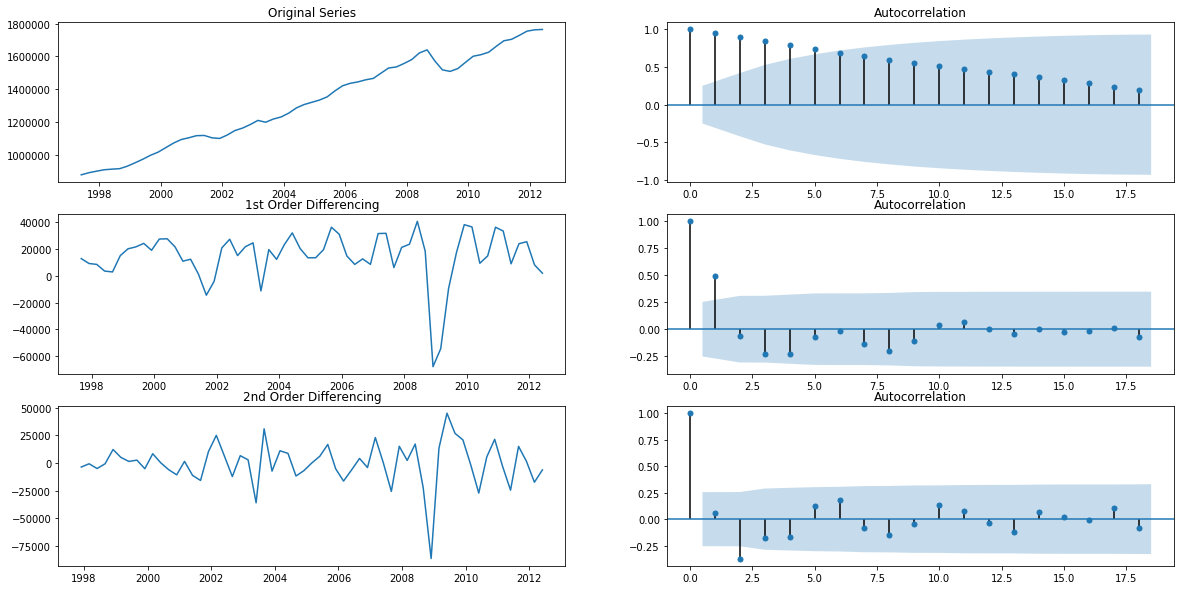

In [23]:
# source https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# determining order of differencing using autocorrelation plots 
plt.rcParams['figure.figsize'] = [20, 10]
# x axis: Lag
df = main_df
df = df.set_index(df["month"])
df["gdp"] = df["gdp"].astype(float)
# plt.rcParams['figure.figsize'] = [10, 5]
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df["gdp"]); axes[0, 0].set_title('Original Series')
plot_acf(df["gdp"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["gdp"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["gdp"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["gdp"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["gdp"].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [24]:
correlation_table = pd.DataFrame(columns= ['Pearson','Spearman'])

names = ['Term Spread', 'Hours Worked in Manufacturing', 'Unemployment Insurance Request', 'Manufacturing New Orders']
for index, i in enumerate(df.columns[1:-1]):
    correlation_table.loc[names[index]] = {'Pearson':stats.pearsonr(df[i], df["gdp"])[0], 
                                          'Spearman':stats.spearmanr(df[i], df["gdp"])[0]}
    
    print("Pearson correlation between {} and GDP:".format(i), stats.pearsonr(df[i], df["gdp"])[0])
    print("Spearman correlation between {} and GDP:".format(i), stats.spearmanr(df[i], df["gdp"])[0])

# Strictly speaking, Pearson’s correlation requires that each dataset be normally distributed. 
# Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. 
# Negative correlations imply that as x increases, y decreases.

Pearson correlation between term_spread and GDP: 0.12545468842056945
Spearman correlation between term_spread and GDP: 0.12279217345319937
Pearson correlation between hours_worked and GDP: -0.8069544028905671
Spearman correlation between hours_worked and GDP: -0.7631411951348491
Pearson correlation between unemployment_insurance and GDP: 0.12960004335062092
Spearman correlation between unemployment_insurance and GDP: 0.10732700498212423
Pearson correlation between mfg_new_orders and GDP: 0.5278747407134562
Spearman correlation between mfg_new_orders and GDP: 0.5035959809624536


In [25]:
correlation_table.loc["TSX60 Index"] = {'Pearson':stats.pearsonr(tsx_df["tsx"], tsx_df["gdp"])[0], 
                                          'Spearman':stats.spearmanr(tsx_df["tsx"], tsx_df["gdp"])[0]}

NameError: name 'tsx_df' is not defined

In [533]:
correlation_table

,Pearson,Spearman
Term Spread,0.242589,0.231788
Hours Worked in Manufacturing,-0.806954,-0.763141
Unemployment Insurance Request,0.129600,0.107327
Manufacturing New Orders,0.527875,0.503596
TSX60 Index,0.811957,0.755159


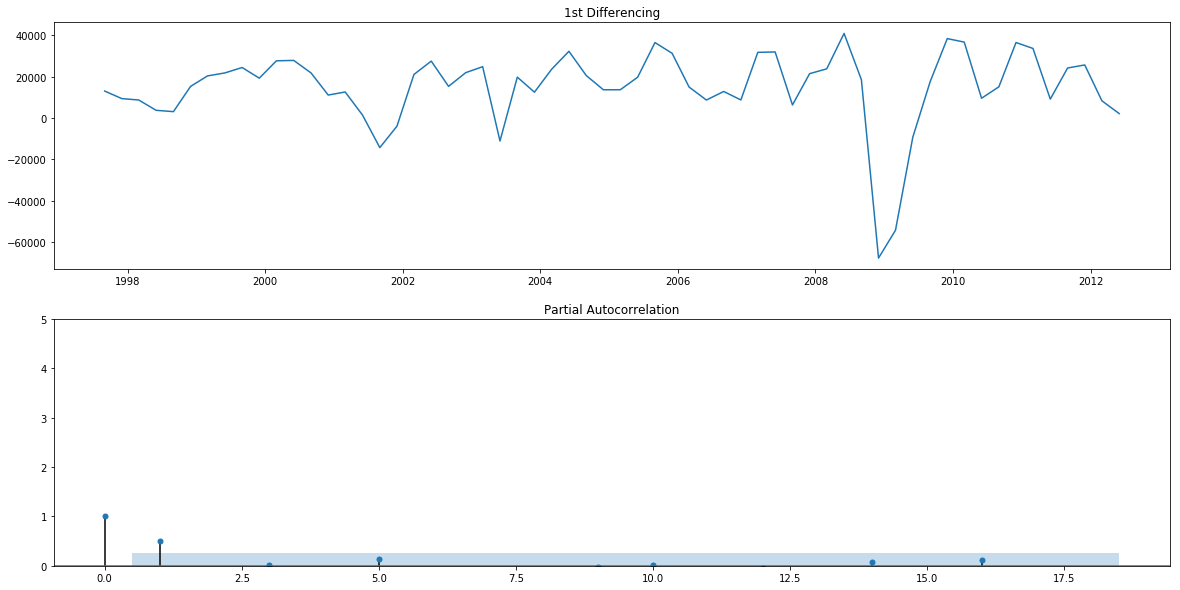

In [26]:
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].plot(df["gdp"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df["gdp"].diff().dropna(), ax=axes[1])

plt.show()

In [36]:
p = 0
d = 1
q = 1

In [37]:
# Forecast
import matplotlib.dates as mdates
import numpy as np

def plot_model(model_fitted, indicator, show=None ):
    plt.rcParams['figure.figsize'] = [15, 5]
    model_fitted.plot_predict(dynamic=False)
#     plt.gca().xaxis_date()
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#     plt.gca().xaxis.set_major_locator(mdates.MonthLocator((3,6,9,12)))
    # plt.xticks(rotation=180)
    plt.xticks(rotation='vertical')
    plt.xlabel("Year")
    plt.ylabel("GDP (CAD)")
#     plt.savefig("results/fitted_after_recession_{}".format(indicator))
    if show!=None:
        plt.show()
    
def arima(train , exogenous=None ):
    model_1= ARIMA(endog=train['gdp'].astype(float), exog=exogenous, order=(p,d,q))
    model_1_fit = model_1.fit()
    print(model_1_fit.summary())
    return model_1, model_1_fit

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'MAPE':mape, 'RMSE':rmse, 'CORR':corr})

def plot_forecasted(model_fitted, train, valid, exogenous = None):
    if exogenous == None:
        fc, se, conf = model_fitted.forecast(len(valid))
        exog_title = "base"
    else:
        fc, se, conf = model_fitted.forecast(len(valid), exog = valid[exogenous])
        exog_title = exogenous
        
    results = forecast_accuracy(fc, valid["gdp"])
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.plot(train.index,train["gdp"].astype(float),label='training')
    plt.plot(valid.index,valid["gdp"].astype(float), label='actual')
    
    plt.plot(valid.index, fc.astype(float), label='forecast')
    plt.gca().xaxis_date()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator((3,6,9,12)))
    # plt.xticks(rotation=180)
    plt.xticks(rotation='vertical')
    plt.xlabel("Date (quarterly)")
    plt.ylabel("GDP (CAD)")

    # plt.gcf().autofmt_xdate()
    # plt.ylim(1000000,2000000)
    # plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                  color='k', alpha=.15)
    plt.title('Forecasted vs Actual GDP')
    plt.legend(loc='upper left', fontsize=8)
    
#     plt.savefig("results/forecast_after_recession_{}.png".format(exog_title))
    plt.show()
    
    return results  

In [38]:
data_with_tsx = data.iloc[183:304].dropna().rename(columns= {'Unnamed: 0':'Month'}).rename(columns={'S&P/TSX: Index: 60': 'tsx60'})
data_with_tsx[data_with_tsx.columns[1:]] = data_with_tsx[data_with_tsx.columns[1:]].astype(float)
non_scaled_data_tsx = data_with_tsx.copy()
tsx_gdp_nonnormalized = non_scaled_data_tsx['Gross Domestic Product (GDP): saar']
tsx_df = pd.DataFrame(OrderedDict({"month":data_with_tsx["Month"], "tsx":data_with_tsx["tsx60"], "gdp":tsx_gdp_nonnormalized}))
tsx_df["month"] =pd.to_datetime(tsx_df["month"])
tsx_df = tsx_df.set_index(tsx_df["month"])

tsx_train = tsx_df[:int(0.55*(len(tsx_df)))]
tsx_valid = tsx_df[int(0.55*(len(tsx_df))):]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.gdp   No. Observations:                   21
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -224.803
Method:                       css-mle   S.D. of innovations          10785.708
Date:                Wed, 06 Nov 2019   AIC                            457.607
Time:                        23:03:18   BIC                            461.785
Sample:                    12-01-2002   HQIC                           458.514
                         - 12-01-2007                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1.43e+04   9861.435      1.450      0.164   -5027.885    3.36e+04
tsx             7.7369     16.428      0.471      0.643     -24.460      39.934
ma.L1.D.gdp     0.0192      0.286      0.067    

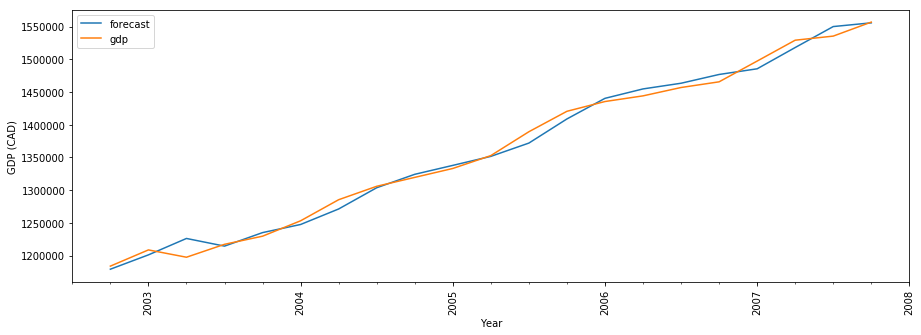

In [39]:
tsx_model, tsx_model_fit = arima(tsx_train, exogenous = tsx_train["tsx"])

# plt.rcParams['figure.figsize'] = [15, 5]
# tsx_model_fit.plot_predict(dynamic=False)
# plt.xlabel 
plot_model(tsx_model_fit, "tsx")
# plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.gdp   No. Observations:                   46
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -509.332
Method:                       css-mle   S.D. of innovations          15481.284
Date:                Wed, 06 Nov 2019   AIC                           1024.664
Time:                        23:04:16   BIC                           1030.150
Sample:                    09-01-1997   HQIC                          1026.720
                         - 12-01-2008                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.411e+04   3750.105      3.762      0.000    6757.588    2.15e+04
ma.L1.D.gdp     0.6559      0.133      4.937      0.000       0.396       0.916
                                    Roots       

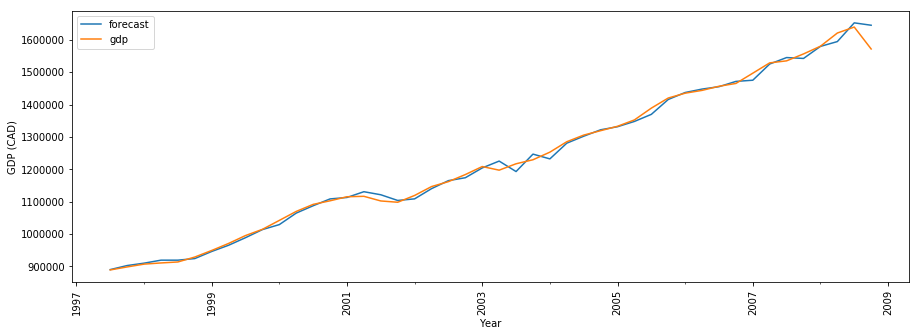

In [45]:
train = df[:int(0.775*(len(df)))]
valid = df[int(0.775*(len(df))):]

model, model_fit = arima(train)

plot_model(model_fit, "base")
# plt.rcParams['figure.figsize'] = [15, 5]
# model_fit.plot_predict(dynamic=False)

# plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.gdp   No. Observations:                   46
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -507.084
Method:                       css-mle   S.D. of innovations          14753.718
Date:                Wed, 06 Nov 2019   AIC                           1022.167
Time:                        23:04:17   BIC                           1029.482
Sample:                    09-01-1997   HQIC                          1024.908
                         - 12-01-2008                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.525e+04   6256.300      4.036      0.000     1.3e+04    3.75e+04
term_spread -2.245e+04   1.06e+04     -2.115      0.040   -4.32e+04   -1649.793
ma.L1.D.gdp     0.6244      0.147      4.233    

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.gdp   No. Observations:                   46
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -505.257
Method:                       css-mle   S.D. of innovations          14216.830
Date:                Wed, 06 Nov 2019   AIC                           1018.514
Time:                        23:04:17   BIC                           1025.828
Sample:                    09-01-1997   HQIC                          1021.254
                         - 12-01-2008                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.331e+04   4776.968      4.879      0.000    1.39e+04    3.27e+04
unemployment_insurance -3.109e+04   1.27e+04     -2.451      0.018    -5.6e+04   -6226.751
ma.L

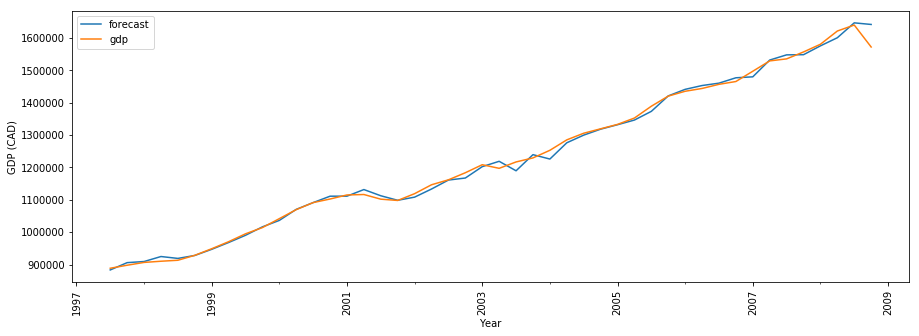

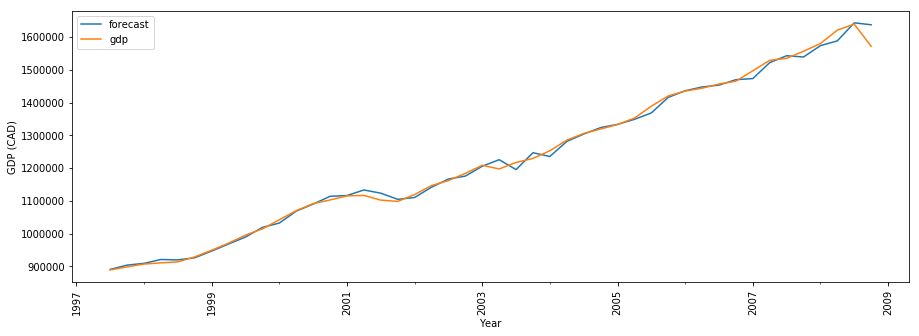

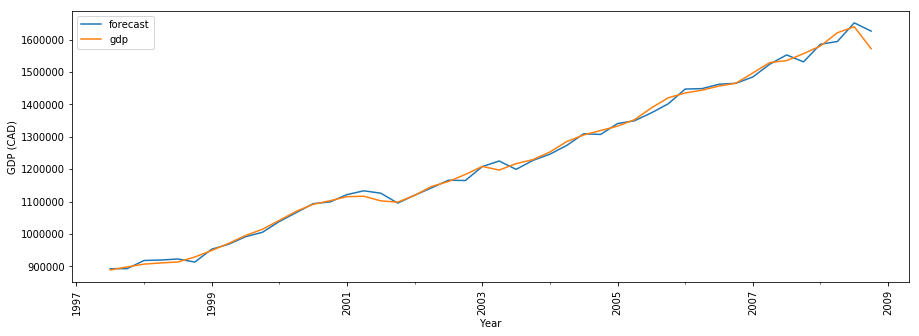

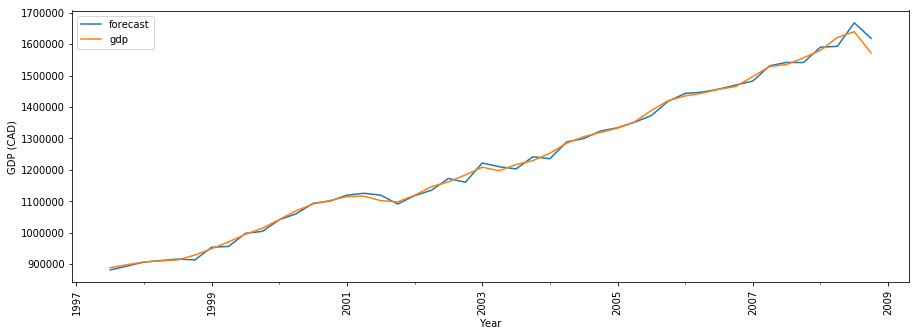

In [46]:
# ['month', 'term_spread', 'hours_worked', 'unemployment_insurance',
#        'mfg_new_orders', 'gdp']

model_term_spread , model_fit_term_spread = arima(train, exogenous = train["term_spread"])

model_hrs, model_fit_hrs = arima(train, exogenous = train["hours_worked"])

model_unemployment, model_fit_unemployment = arima(train, exogenous = train["unemployment_insurance"] )

model_orders, model_fit_orders = arima(train, exogenous = train["mfg_new_orders"])

plot_model(model_fit_term_spread, "spread")
plot_model(model_fit_hrs, "hours_worked")
plot_model(model_fit_unemployment, "unemployment")
plot_model(model_fit_orders, "orders_mfg")



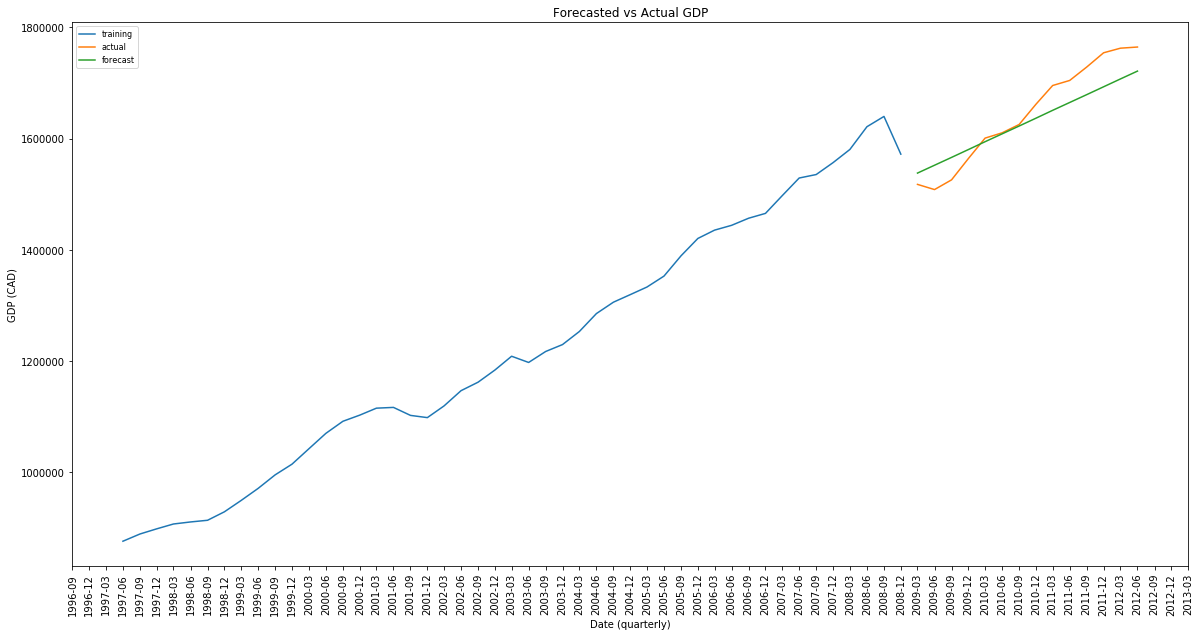

In [47]:
base_forecast = plot_forecasted(model_fit, train, valid)

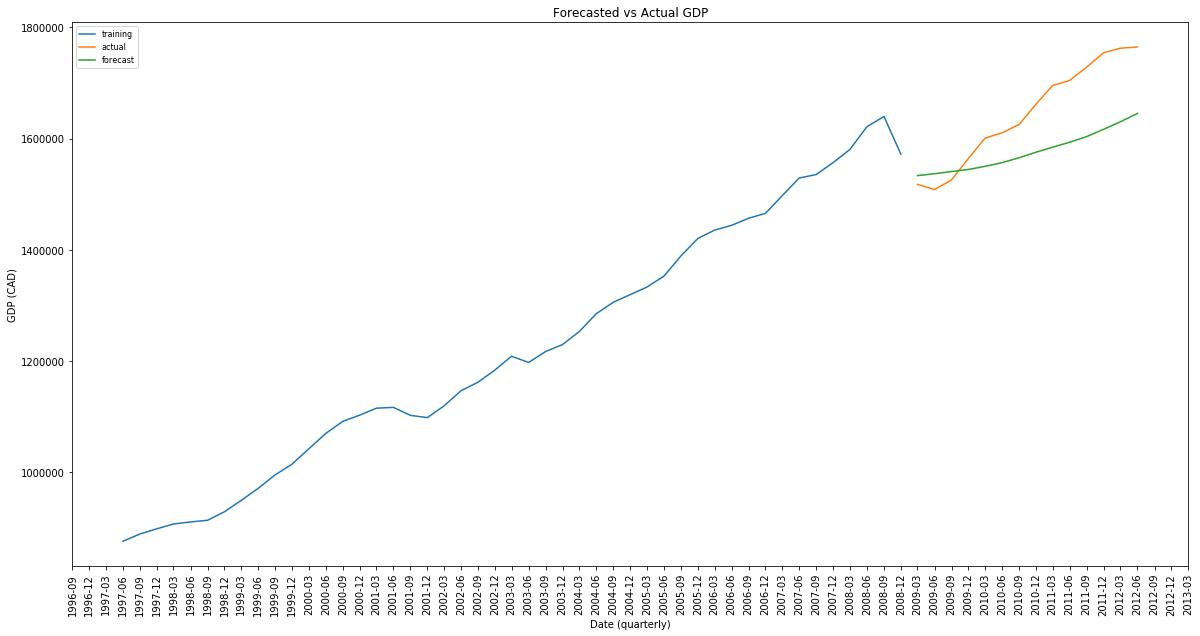

In [49]:
spread_forecast = plot_forecasted(model_fit_term_spread,train, valid, exogenous = "term_spread")

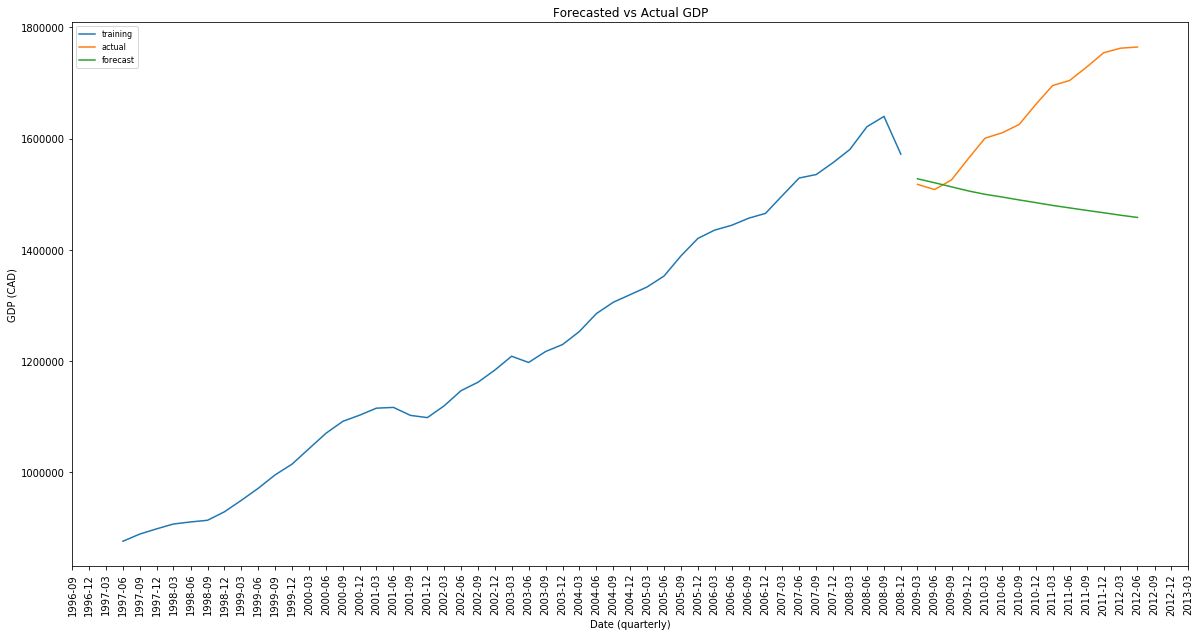

In [50]:
hours_forecast =plot_forecasted(model_fit_hrs, train, valid,exogenous = "hours_worked")

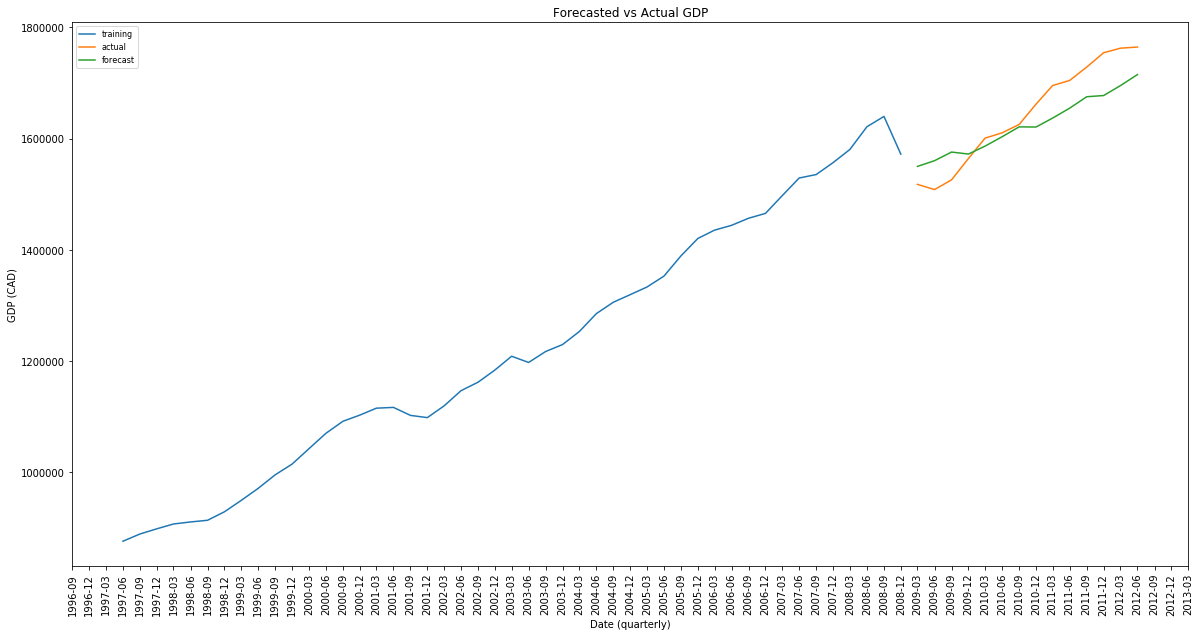

In [51]:
unemployment_forecast = plot_forecasted(model_fit_unemployment,train, valid, exogenous = "unemployment_insurance")

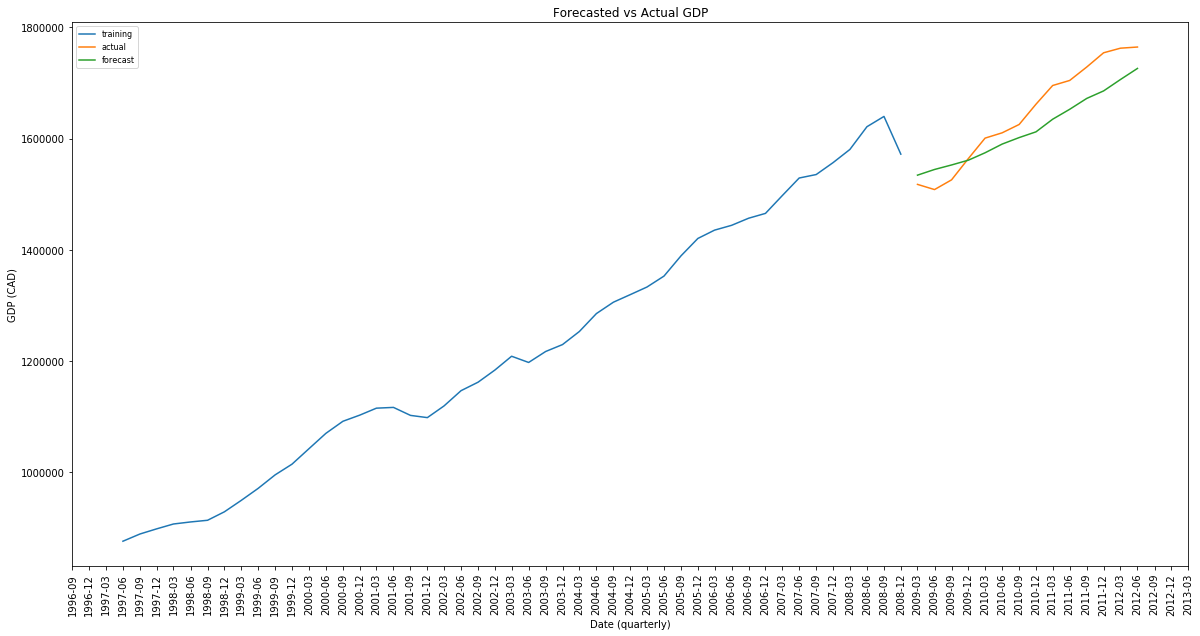

In [52]:
orders_forecast = plot_forecasted(model_fit_orders, train, valid,exogenous = "mfg_new_orders")

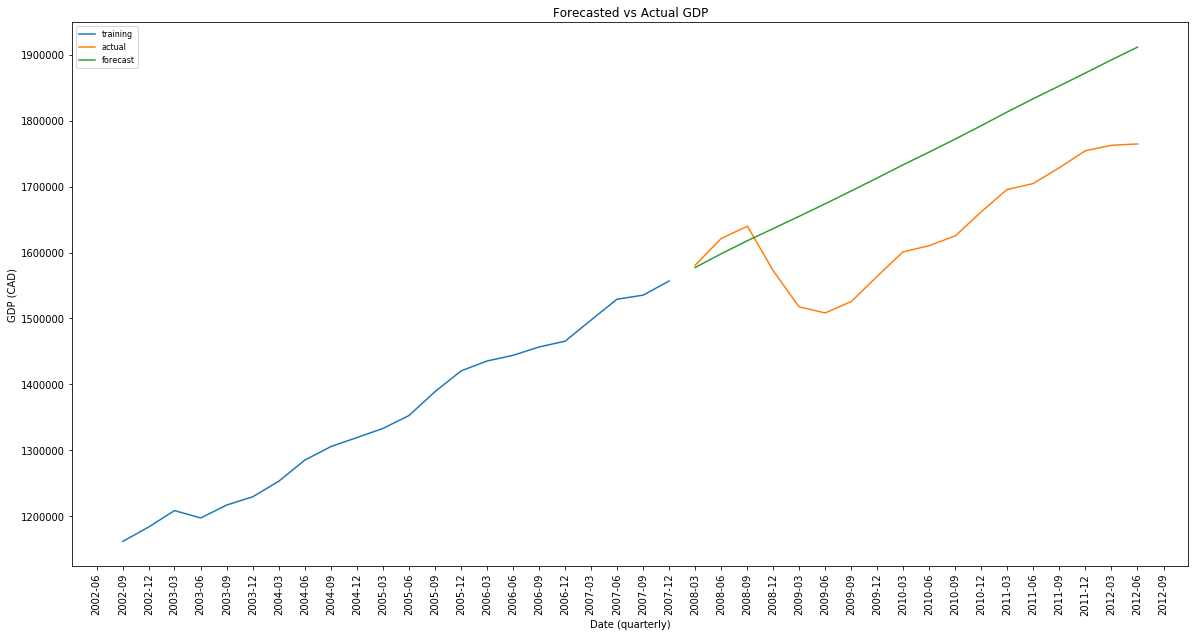

In [53]:
tsx_forecast = plot_forecasted(tsx_model_fit, tsx_train, tsx_valid,exogenous = "tsx")

In [54]:
results_df = pd.DataFrame(columns =['MAPE','RMSE', 'CORR'])

factors = ['Univariate', 'Term Spread', 'Hours Worked in Manufacturing', 'Unemployment Insurance Request', 'Manufacturing New Orders', "TSX60 Index"]
errors = [base_forecast,spread_forecast, hours_forecast, unemployment_forecast, orders_forecast, tsx_forecast]

In [55]:
for index, i in enumerate(factors):
    results_df.loc[i] = errors[index]
    

In [56]:
results_df

,MAPE,RMSE,CORR
Univariate,0.019301,37416.925979,0.990307
Term Spread,0.044973,88297.664653,0.962408
Hours Worked in Manufacturing,0.093145,190774.821137,-0.988450
Unemployment Insurance Request,0.024221,46234.804040,0.973992
Manufacturing New Orders,0.022823,42554.773239,0.977620
TSX60 Index,0.069780,123801.953329,0.809949
